In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Import Libraries

In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import os
import glob 
import numpy as np 
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import plotly.express as px
from tqdm.notebook import tqdm, trange
sys.path.append('../')
from src.train_config import config

### Read OCT2017 training set (raw set) and print info

In [6]:
train_csv_path = "/data/oct_train_all.csv"

In [7]:
train = pd.read_csv(train_csv_path)

In [8]:
train = train.sample(frac=1).reset_index(drop=True) #shuffle dataframe

In [9]:
print("size of train set: {0}".format(len(train)))


size of train set: 83484


In [10]:
train.head()

path   label  label_int  kfold
0  /data/OCT2017/train\DRUSEN\DRUSEN-732516-29.jpeg  DRUSEN          2      2
1        /data/OCT2017/train\CNV\CNV-7393104-4.jpeg     CNV          3      0
2       /data/OCT2017/train\DME\DME-4792882-56.jpeg     DME          1      2
3        /data/OCT2017/train\DME\DME-1163718-3.jpeg     DME          1      0
4        /data/OCT2017/train\DME\DME-7585414-4.jpeg     DME          1      2

### Check number of instances per class

In [12]:
#histogram  of labels
fig = px.histogram(train, x="label",nbins=10)
fig.show()

### Compute height, weight, and width/height ratio of instances

In [25]:
# train['path'][i].replace('\\','/')
train['path'] = train['path'].apply(lambda x: x.replace('\\','/')).reset_index(drop=True)

In [26]:
train.head()

path   label  label_int  kfold  \
0  /data/OCT2017/train/DRUSEN/DRUSEN-732516-29.jpeg  DRUSEN          2      2   
1        /data/OCT2017/train/CNV/CNV-7393104-4.jpeg     CNV          3      0   
2       /data/OCT2017/train/DME/DME-4792882-56.jpeg     DME          1      2   
3        /data/OCT2017/train/DME/DME-1163718-3.jpeg     DME          1      0   
4        /data/OCT2017/train/DME/DME-7585414-4.jpeg     DME          1      2   

   width  height  width_height_ratio  width_height_added  
0    512     496             0.96875                1008  
1    512     496             0.96875                1008  
2    512     512             1.00000                1024  
3    512     496             0.96875                1008  
4    512     512             1.00000                1024

In [15]:
# get height and width info of the set 
train_width, train_height = [], []
for i in tqdm(range(len(train))):
    image = Image.open(train['path'][i].replace('\\','/'))
    width, height = image.size
    train_width.append(width)
    train_height.append(height)

In [16]:
train['width'] = train_width
train['height'] = train_height

In [17]:
for df in [train]:
    df['width_height_ratio'] = df['height'] / df['width']
    df['width_height_added'] = df['height'] + df['width']

In [18]:
train.head()

path   label  label_int  kfold  \
0  /data/OCT2017/train\DRUSEN\DRUSEN-732516-29.jpeg  DRUSEN          2      2   
1        /data/OCT2017/train\CNV\CNV-7393104-4.jpeg     CNV          3      0   
2       /data/OCT2017/train\DME\DME-4792882-56.jpeg     DME          1      2   
3        /data/OCT2017/train\DME\DME-1163718-3.jpeg     DME          1      0   
4        /data/OCT2017/train\DME\DME-7585414-4.jpeg     DME          1      2   

   width  height  width_height_ratio  width_height_added  
0    512     496             0.96875                1008  
1    512     496             0.96875                1008  
2    512     512             1.00000                1024  
3    512     496             0.96875                1008  
4    512     512             1.00000                1024

### Plot histogram of height/weight, width/height and height/width ratio

Text(0.5, 1.0, 'train width height added')

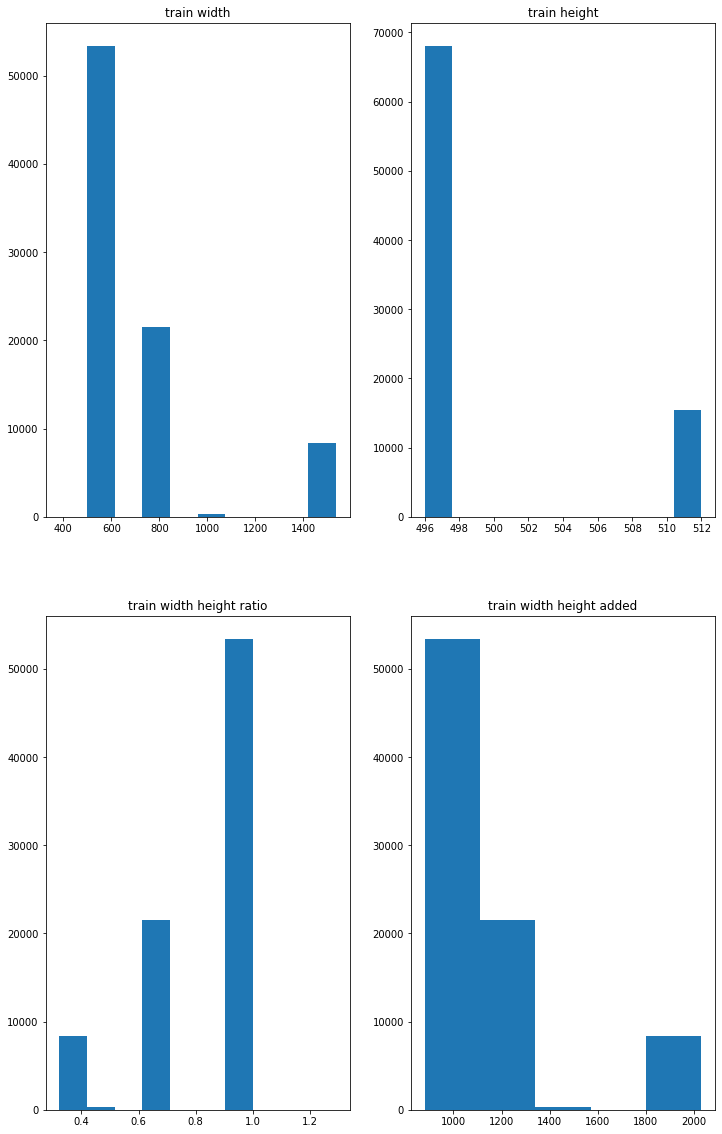

In [19]:
fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.hist(train['width'])
ax1.set_title("train width")

ax2.hist(train['height'])
ax2.set_title("train height")

ax3.hist(train['width_height_ratio'])
ax3.set_title("train width height ratio")

ax4.hist(train['width_height_added'], bins=5)
ax4.set_title("train width height added")




### Print statistics about the histogram values plotted above

In [20]:
train['width_height_added'].describe()

count    83484.000000
mean      1181.055436
std        304.705914
min        880.000000
25%       1008.000000
50%       1024.000000
75%       1264.000000
max       2032.000000
Name: width_height_added, dtype: float64

In [21]:
train['width'].describe()

count    83484.000000
mean       682.093239
std        306.291991
min        384.000000
25%        512.000000
50%        512.000000
75%        768.000000
max       1536.000000
Name: width, dtype: float64

In [22]:
train['height'].describe()

count    83484.000000
mean       498.962196
std          6.214579
min        496.000000
25%        496.000000
50%        496.000000
75%        496.000000
max        512.000000
Name: height, dtype: float64

In [23]:
train.groupby(['label'])['width_height_added'].mean()


label
CNV       1232.372423
DME       1072.996828
DRUSEN    1166.692665
NORMAL    1159.803306
Name: width_height_added, dtype: float64

### Visualize few samples from each class

In [27]:
# Visualinze Train Images
train_class0 = [] 
train_class1 = []
train_class2 = []
train_class3 = []


num_sample = 10

for path in train[train.label_int == 0].sample(num_sample)['path']:
    im = Image.open(path)
    train_class0.append(im)
for path in train[train.label_int == 1].sample(num_sample)['path']:
    im = Image.open(path)
    train_class1.append(im)
    
for path in train[train.label_int == 2].sample(num_sample)['path']:
    im = Image.open(path)
    train_class2.append(im)
    
for path in train[train.label_int == 3].sample(num_sample)['path']:
    im = Image.open(path)
    train_class3.append(im)
    

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
def visualize_samples(sample_list,class_name,columns=5):
    plt.figure(figsize=(20,10))
    columns = 5
    plt.suptitle("Class {0}".format(class_name)) 
    for i, image in enumerate(sample_list):
        plt.subplot(len(sample_list) / columns + 1, columns, i + 1)
        plt.imshow(image, cmap="gray")


In [30]:
label_encoder={'CNV':3, 'DME':1,'DRUSEN':2,'NORMAL':0}

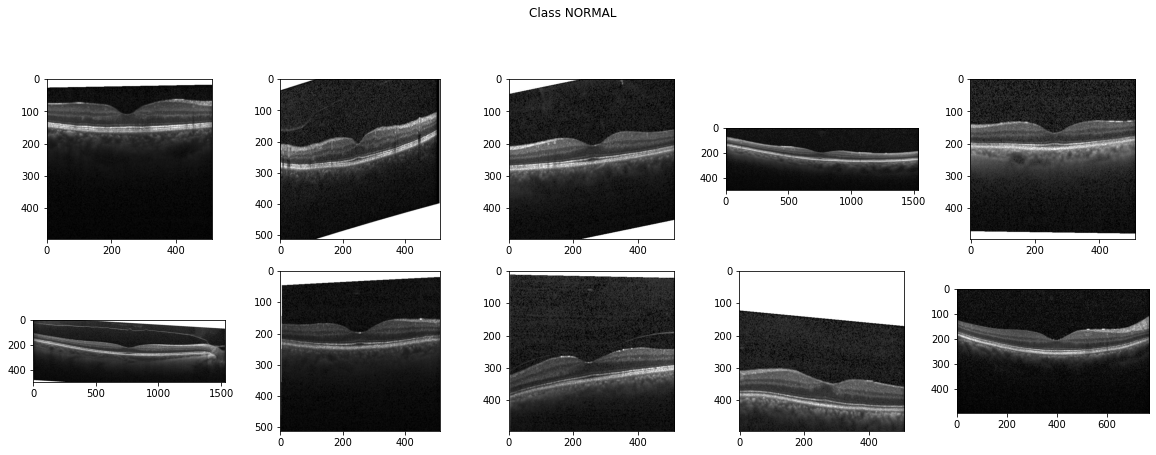

In [31]:
visualize_samples(train_class0,"NORMAL",columns=5)

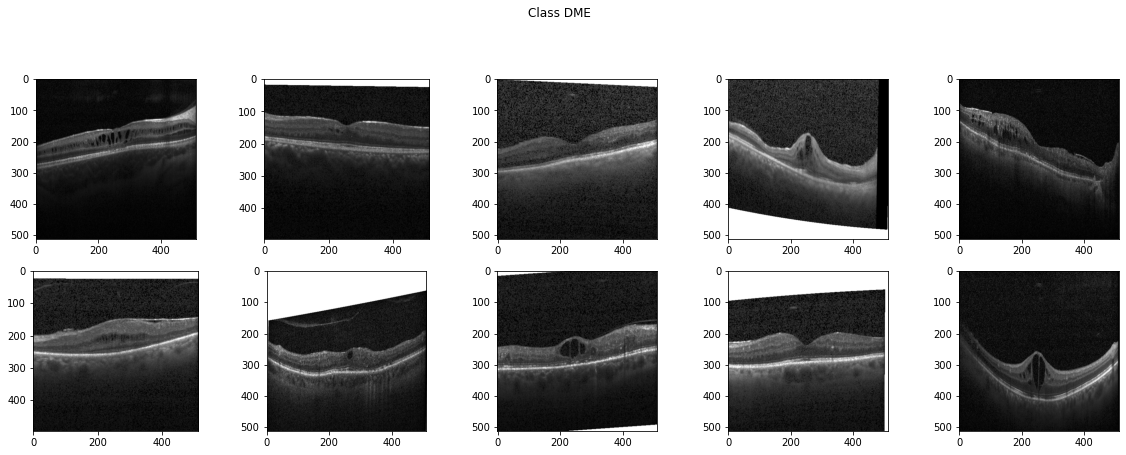

In [32]:
visualize_samples(train_class1,"DME",columns=5)

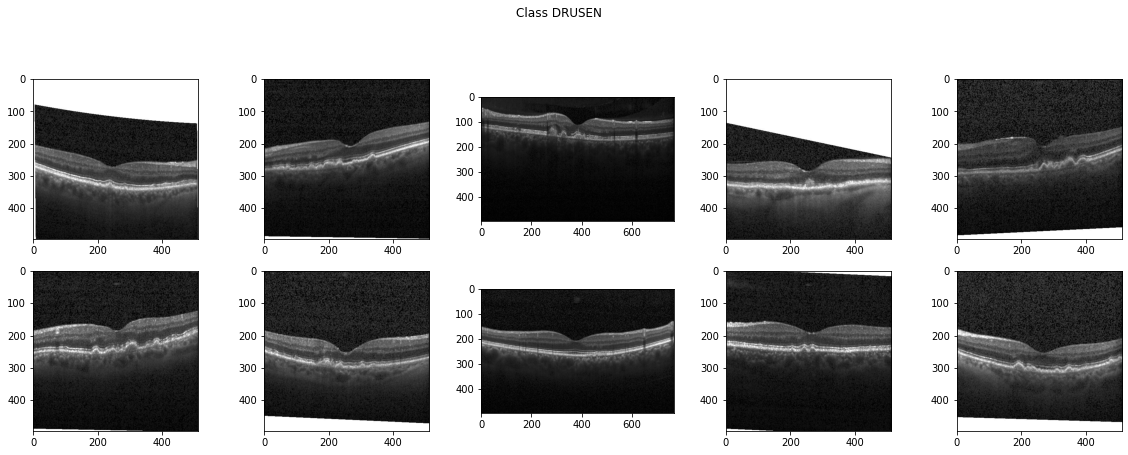

In [33]:
visualize_samples(train_class2,"DRUSEN",columns=5)

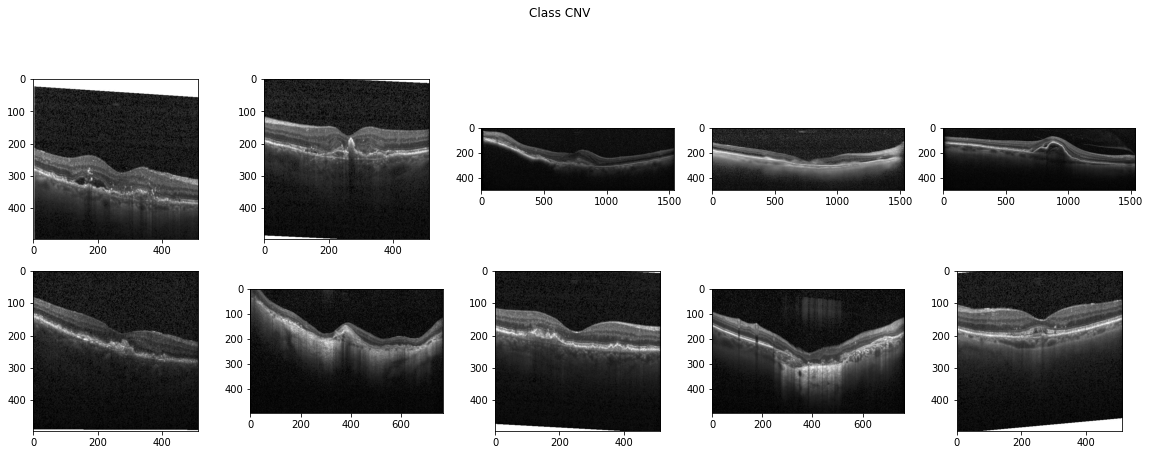

In [34]:
visualize_samples(train_class3,"CNV",columns=5)

### Plot large and small size samples(randomly)

In [35]:
# small and large images
train_image_small = []
train_image_large = []

for path in train[train.width_height_added < 1010].sample(30)['path']:
    im = Image.open(path)
    train_image_small.append(im)
    
for path in train[train.width_height_added > 1260].sample(30)['path']:
    im = Image.open(path)
    train_image_large.append(im)

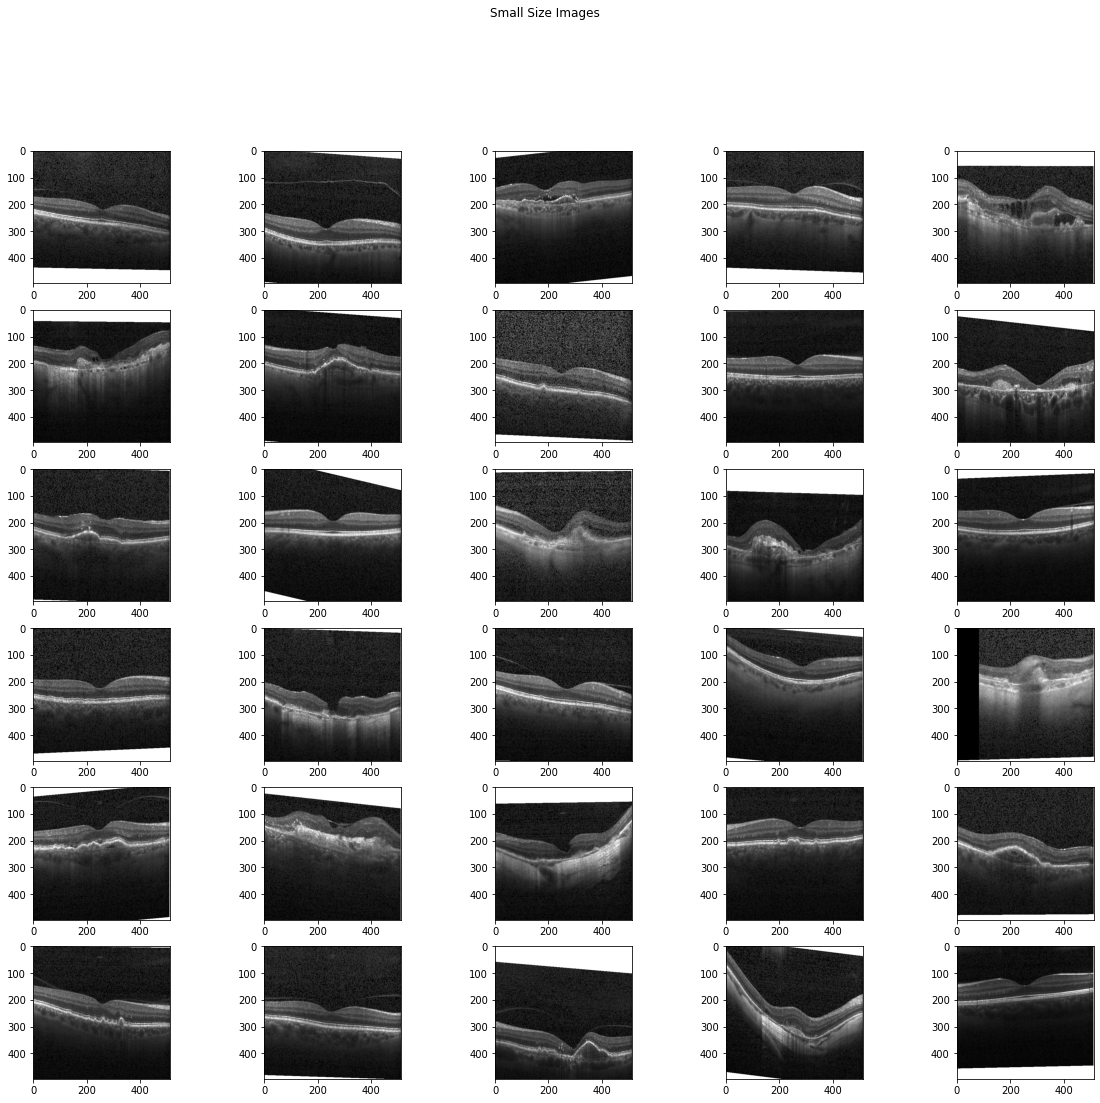

In [36]:
plt.figure(figsize=(20,20))
columns = 5
plt.suptitle("Small Size Images")
for i, image in enumerate(train_image_small):
    plt.subplot(len(train_image_small) / columns + 1, columns, i + 1)
    plt.imshow(image,cmap="gray")

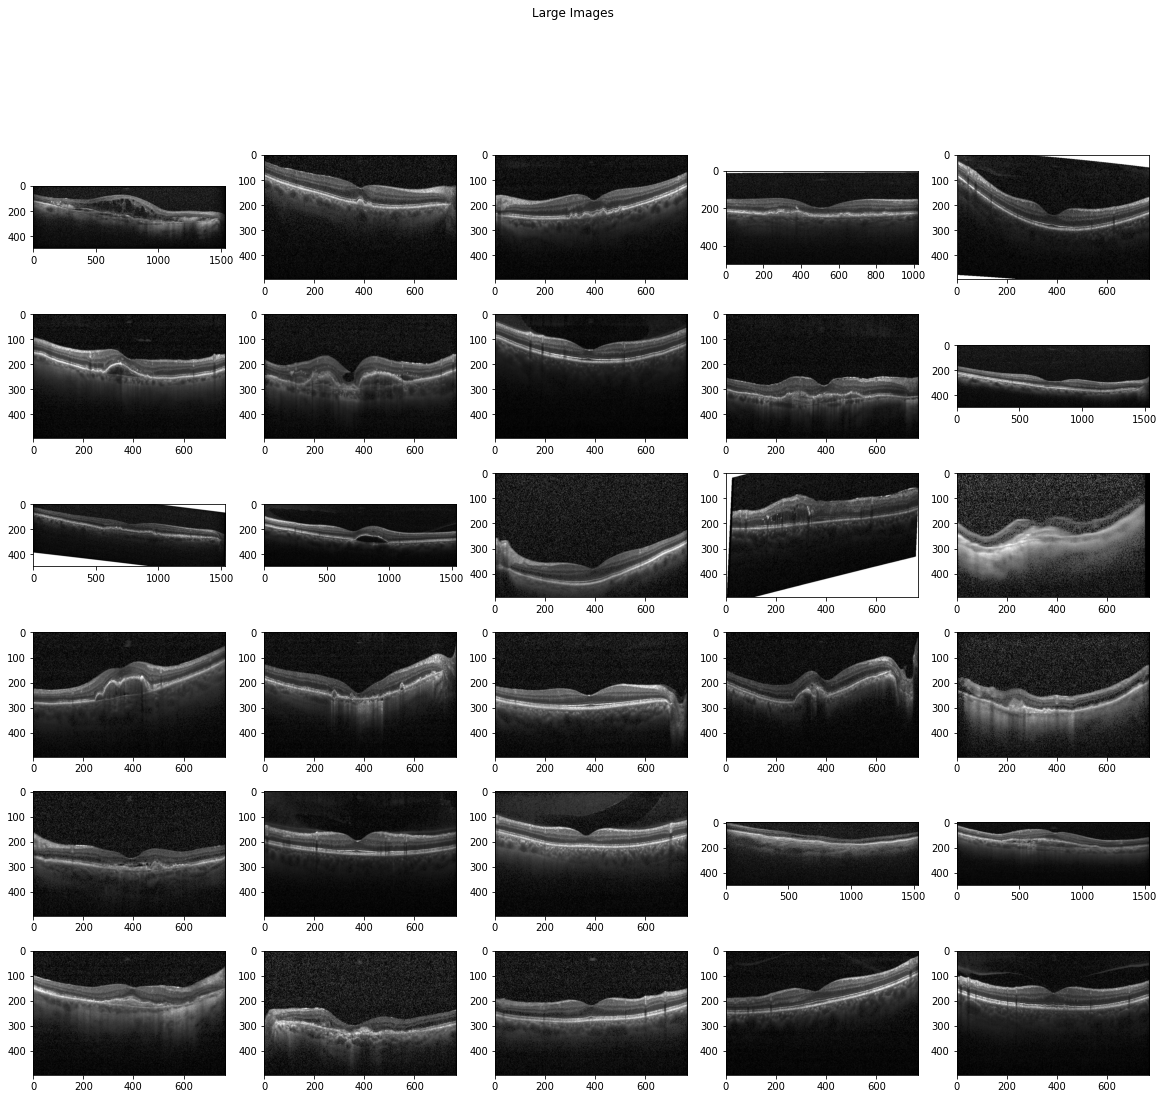

In [37]:
plt.figure(figsize=(20,20))
columns = 5
plt.suptitle("Large Images")
for i, image in enumerate(train_image_large):
    plt.subplot(len(train_image_large) / columns + 1, columns, i + 1)
    plt.imshow(image,cmap="gray")